In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
plt.rcParams['figure.figsize'] = (16, 4)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm

from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
warnings.filterwarnings("ignore") # specify to ignore warning messages

import utils

In [53]:
farm1 = pd.read_csv('data/wf1_data.csv')
farm2 = pd.read_csv('data/wf2_data.csv')
farm3 = pd.read_csv('data/wf3_data.csv')

farm1['date'] = pd.to_datetime(farm1['date'], format = '%Y%m%d%H')
farm2['date'] = pd.to_datetime(farm2['date'], format = '%Y%m%d%H')
farm3['date'] = pd.to_datetime(farm3['date'], format = '%Y%m%d%H')

farm1_orig = farm1.set_index('date').sort_index()
farm2_orig = farm2.set_index('date').sort_index()
farm3_orig = farm3.set_index('date').sort_index()

farm1 = farm1_orig.dropna()
farm2 = farm2_orig.dropna()
farm3 = farm3_orig.dropna()


### Farm 3

In [54]:
farm3 = farm3.resample('h').mean()
farm3.tail()

,wp,ws
date,,
2010-06-29 19:00:00,0.468,9.97
2010-06-29 20:00:00,0.661,9.86
2010-06-29 21:00:00,0.485,9.48
2010-06-29 22:00:00,NaN,NaN
2010-06-29 23:00:00,0.402,8.02


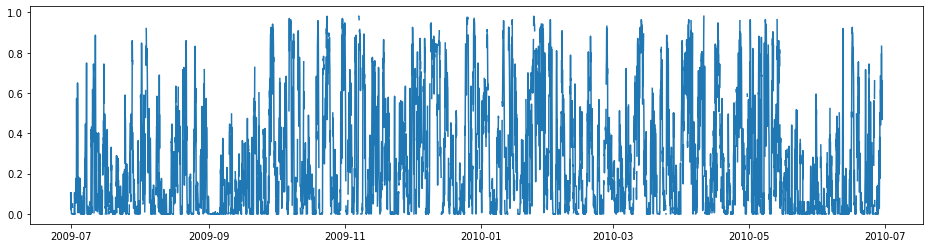

In [11]:
plt.plot(farm3.wp)

In [26]:
farm3.shape #(8759, 2)
# farm3_subset = farm3.loc['oct 2009':].dropna()#(5941, 2)

(8759, 2)

In [55]:
farm3['wp'] = farm3.wp.interpolate()
farm3['ws'] = farm3.ws.interpolate()

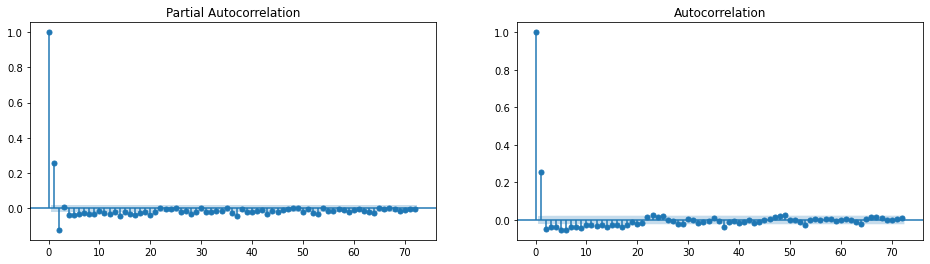

In [28]:
#Farm3
fig, ax = plt.subplots(1,2)
plot_pacf(farm3['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[0], method='ols')  
plot_acf(farm3['wp'].diff().dropna(), alpha=.05, lags=72, ax=ax[1])  
plt.show()

In [60]:
farm3_exog_train = farm3[:-24].drop('wp', axis=1)
farm3_exog_test  = farm3[-24:].drop('wp', axis=1)

farm3_train = farm3[:-24].drop('ws', axis=1)
farm3_test  = farm3[-24:].drop('ws', axis=1)



In [61]:
sarimax_pipeline_exog_f3 = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog_f3.fit(farm3_train,farm3_exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-15832.574, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19023.696, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19492.321, Time=0.79 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-19615.954, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-19003.762, Time=0.72 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-19636.025, Time=1.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-19670.271, Time=1.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-19670.389, Time=0.94 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-19669.301, Time=1.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-19665.989, Time=1.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-19672.435, Time=0.93 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-19494.340, Time=0.69 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-19671.262, Time=1.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-19672.283, Time=0.98 sec
 ARIM

Pipeline(steps=[('arima',
                 AutoARIMA(maxiter=20, method='nm', suppress_warnings=True,
                           trace=True))])

In [62]:
pred_exog_f3 = sarimax_pipeline_exog_f3.predict(24,farm3_exog_test)
mean_absolute_error(pred_exog_f3,farm3_test)

0.09342221671687706

In [83]:
#nova estimativa para incluir o test set
# sarimax_pipeline_exog_f3.fit(pd.concat([farm3_train,farm3_test]),pd.concat([farm3_exog_train,farm3_exog_test]))


In [84]:
# pred_f3_1day = sarimax_pipeline_exog_f3.predict(24,pd.DataFrame(farm3_orig.ws[-24:]))
# plt.plot(pd.Series(pred_f3_1day, index=farm3_orig[-24:].index), label='pred')
# plt.plot(farm3_orig[-24:].wp, label='original')
# plt.legend();

### Farm 2

In [72]:
farm2_exog_train = farm2[:-24].drop('wp', axis=1)
farm2_exog_test  = farm2[-24:].drop('wp', axis=1)

farm2_train = farm2[:-24].drop('ws', axis=1)
farm2_test  = farm2[-24:].drop('ws', axis=1)

In [73]:
sarimax_pipeline_exog_f2 = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog_f2.fit(farm2_train,farm2_exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16457.241, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16067.536, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16254.494, Time=0.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16298.825, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16049.145, Time=0.69 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16505.846, Time=1.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16348.520, Time=1.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16321.274, Time=0.94 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16479.757, Time=1.37 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16394.304, Time=1.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16419.712, Time=0.95 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-16482.421, Time=1.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-16511.643, Time=1.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-16350.565, Time=0.99 sec
 ARIM

Pipeline(steps=[('arima',
                 AutoARIMA(maxiter=20, method='nm', suppress_warnings=True,
                           trace=True))])

In [74]:
pred_exog_f2 = sarimax_pipeline_exog_f2.predict(24,farm2_exog_test)
mean_absolute_error(pred_exog_f2,farm2_test)


0.37834937099245347

In [77]:
farm2_exog_train2 = farm2[:-48].drop('wp', axis=1)
farm2_exog_test2  = farm2[-48:-24].drop('wp', axis=1)

farm2_train2 = farm2[:-48].drop('ws', axis=1)
farm2_test2  = farm2[-48:-24].drop('ws', axis=1)

In [81]:
sarimax_pipeline_exog_f2_v2 = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog_f2_v2.fit(farm2_train2,farm2_exog_train2)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16421.310, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16032.665, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16218.094, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16262.372, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16015.736, Time=0.69 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16466.675, Time=1.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16312.348, Time=1.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16284.524, Time=0.94 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16435.586, Time=1.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16359.146, Time=1.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16385.020, Time=0.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-16442.607, Time=1.38 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-16460.067, Time=0.97 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 12.757 sec

Pipeline(steps=[('arima',
                 AutoARIMA(maxiter=20, method='nm', suppress_warnings=True,
                           trace=True))])

In [82]:
pred_exog_f2_v2 = sarimax_pipeline_exog_f2_v2.predict(24,farm2_exog_test2)
mean_absolute_error(pred_exog_f2_v2,farm2_test2)


0.1761614106932288